## Developing an Embedding Layer

Essentially an embedding layer is a mapping from discrete objects, such as words, to points in a vector space. The whole purpose of an embedding layer it is to transform our input data into a format that the decoder of our GPT model can parse. Notice that the choice of discrete objects is ours, we can choose words, sentences, paragraphs, etc. We will focus on word embeddings.

## Word Embeddings

Because of the popularity of word embeddings, several algorithms have been develop that transform a word into a vector. One famous algorithm is **Word2Vec**. This algorithm  will turn words into vectors in such a way that words that have similar semantic meaning will be mapped to vectors that are close to each other. 
Word2Vec utilizes a simple neural network to achieve this. 

We can use a pretrained model like Word2Vec for our Embedding layer, but LLMs commonly produce their own embeddings that are part of the input layer and are updated while training. The advantage of this approach is that the embeddings are optimized for the specific task and given data.

## Tokenizing

An embedding algorithm requires a unit of text to embed. This unit of text will be called a token.These tokens will be individual words or special characters. 

After text has been tokenized, we will transform these tokens into an integer representation known as a token ID. This last step is done mostly for efficiency, not because it is mathematically necessary. We could directly map tokens to embeddings, but this would make lookups slower since strings are larger to compare than integers. Moreover, storing string keys for millions of tokens wastes memory. Finally, we have that we can't use the "matrix trick".

 In order to perform this transformation we need to define a mapping between the tokens in our text (the vocabulary) and their corresponding token IDs. 

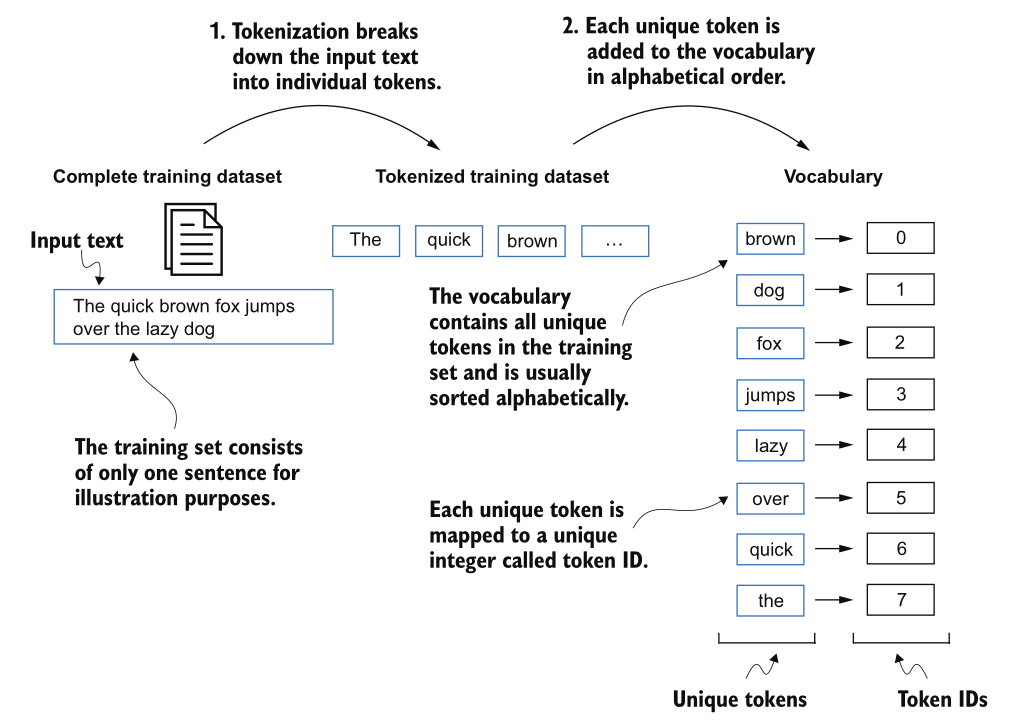

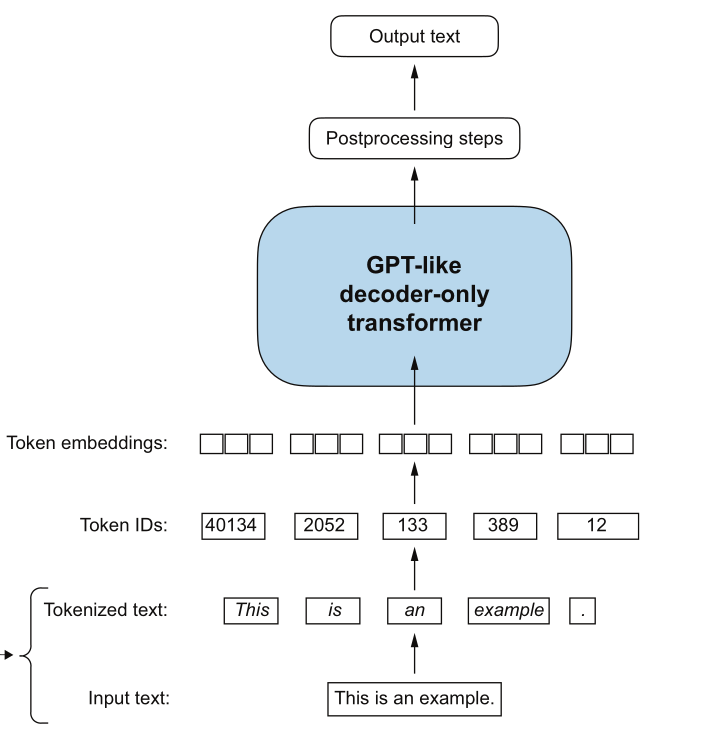

We will tokenize "Afterward" which was written by Edith Wharton.

In [2]:
try: 
    with open("../data/Afterward-Edith-Wharton.txt", "r") as file:
        text = file.read()
except Exception as e:
    print("Error opening the file.")

In [3]:
# Let's print the number of characters
print(len(text))

67689


## Special Tokens ##

Special tokens are utilized to provide context to an LLM. Some examples of special tokens are tokens for unknown words, tokens for document boundaries and tokens for padding.

- <unk\>: It represents a word not in the vocabulary
- <pad\>: Fill the space in a sequence so that all sequences in a batch have the same size 
- <eos\>: marks the end of a text sequence.

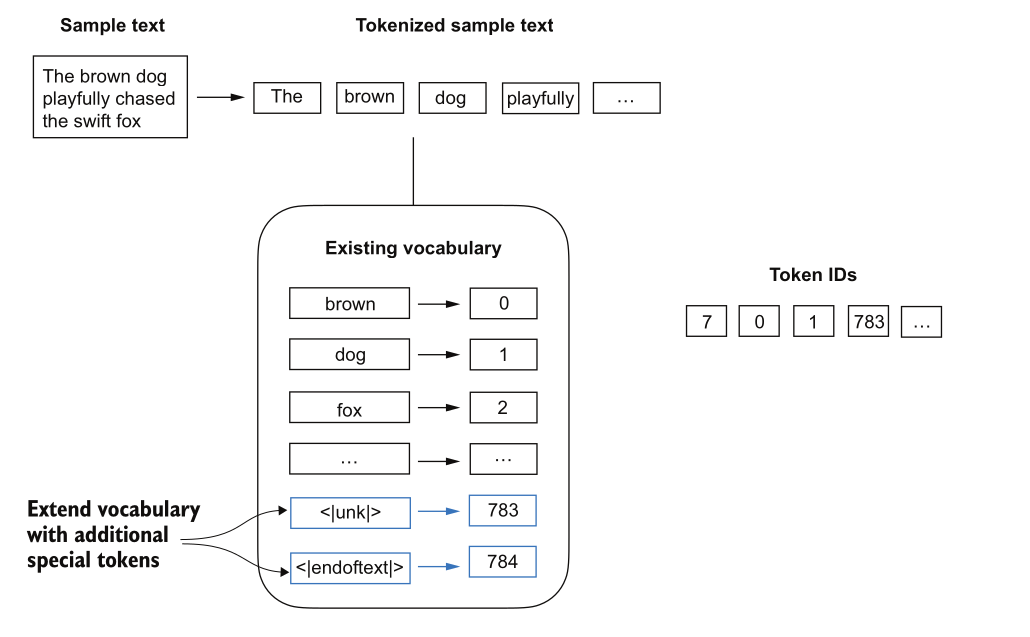

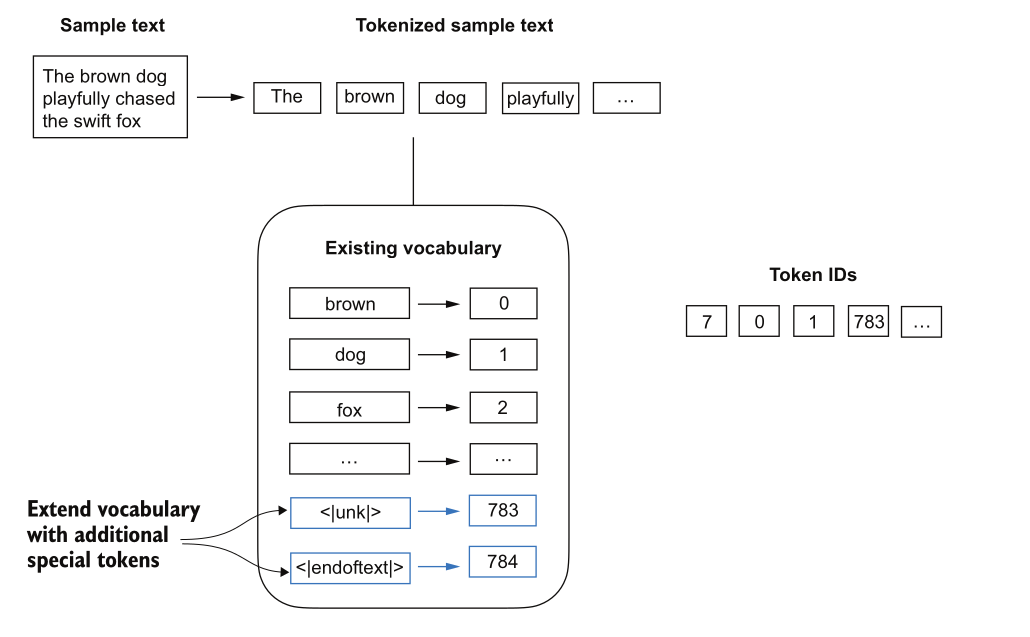

## GPT Special Tokens

The tokenizer for GPT only uses a `<endoftext>` special token. This token is also used for the padding. Now, the GPT tokenizer does not require an `<|unk|>` token since it uses **byte pair encoding**  

### Byte Pair Encoding

The BPE tokenizer encodes and decodes unknown words without having to use an special token. How can it do this? Well, when the BPE algorithm receives an unknown word, it breaks it down into components, enabling it to handle it. 

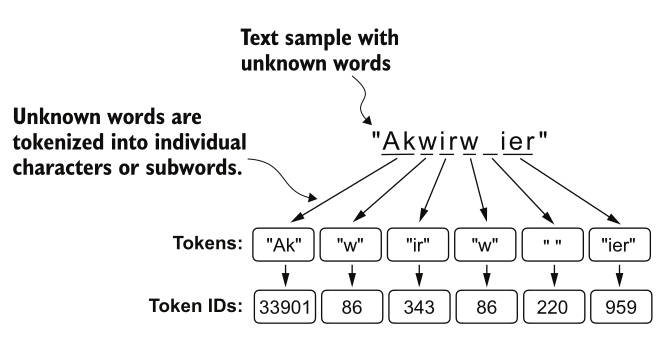

## Data Sampling with Sliding Window

The next step before generating the embeddings is to "label" our data. In other words we want to be able to generate the input-label pairs required for training the model. Since the goal of the GPT model is to predict the next word in a sequence of words, this will look like as follow:  

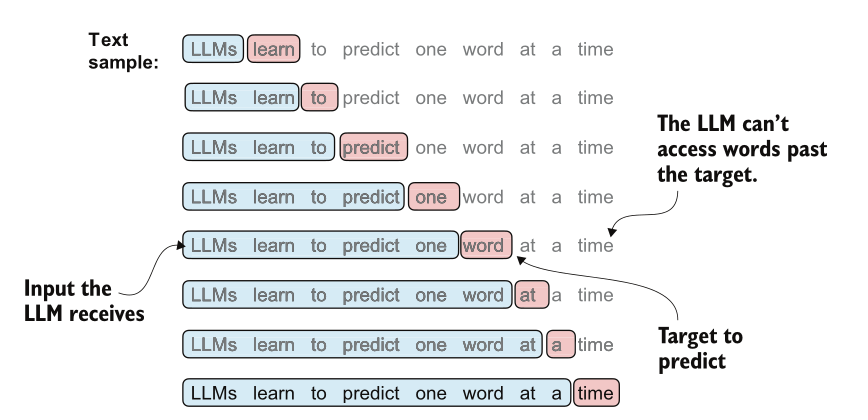

In [4]:
import tiktoken # BPE tokenizer

tokenizer = tiktoken.get_encoding("gpt2")

# Let's tokenize the text with BPE
input_tokens = tokenizer.encode(text=text)

# x will contain our input, and y our label

context_size = 8 # The number of tokens allowed in the input
x = input_tokens[:context_size]
y = input_tokens[1: context_size]

print(f"x: {x}")
print(f"y:       {y}")

x: [8579, 5781, 39743, 220, 198, 7407, 342, 854]
y:       [5781, 39743, 220, 198, 7407, 342, 854]


These $x$ and $y$ provide us with enough information to generate all the input-label sequences:

In [5]:
for i in range(context_size):

    if i == context_size -1 :
        break
    
    context = x[:i+1]
    desired = 0

    desired = y[i]
        
    print(context, "---->", desired)

[8579] ----> 5781
[8579, 5781] ----> 39743
[8579, 5781, 39743] ----> 220
[8579, 5781, 39743, 220] ----> 198
[8579, 5781, 39743, 220, 198] ----> 7407
[8579, 5781, 39743, 220, 198, 7407] ----> 342
[8579, 5781, 39743, 220, 198, 7407, 342] ----> 854


With the $x$ and $y$ at our disposal, we just need to implement a data loader that iterates over these and returns the inputs and labels as Pytorch tensors. To be precise, we want two tensors: one for the text the LLM sees and another for the label it needs to predict.

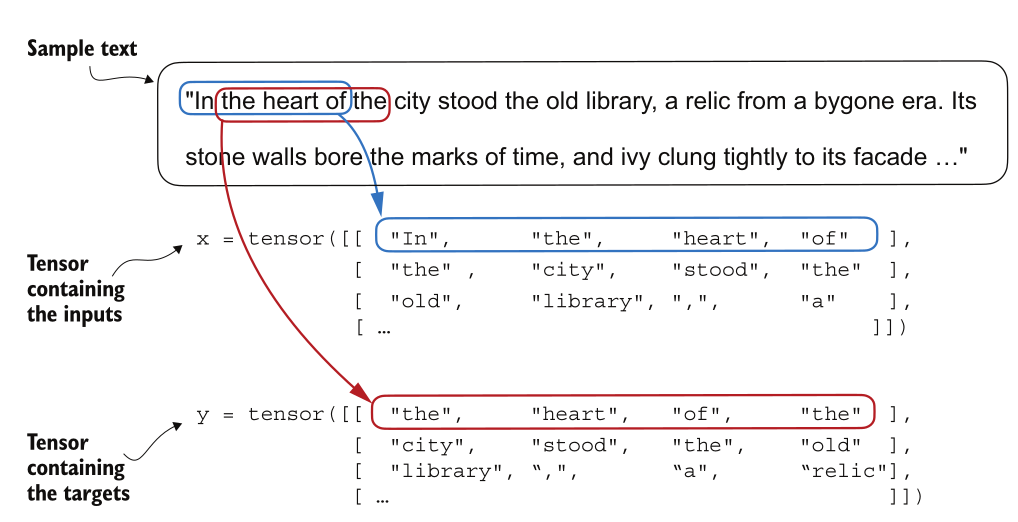

Let's create a Pytorch dataset and dataloader in order to do this. Notice that a Pytorch `Dataset` stores samples and their corresponding labels, while `DataLoader` wraps an iterable around `Dataset`.

In [6]:
import torch
import tiktoken
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):

    def __init__(self, text, tokenizer, context_size, stride):
        self.input_tokenIDs = []    
        self.target_tokenIDs = []
    
    ## Tokenize the data

        tokenized_data = tokenizer.encode(text)
        end = len(tokenized_data) - context_size

        for i in range(0, end, stride):

            x = tokenized_data[i:i + context_size]
            y = tokenized_data[i + 1: i + context_size + 1]

            self.input_tokenIDs.append(torch.tensor(x))
            self.target_tokenIDs.append(torch.tensor(y))



    # Return the length of the dataset    
    def __len__(self):
        return len(self.input_tokenIDs)
    
    # Returns a single row from the dataset
    def __getitem__(self, idx):
        return self.input_tokenIDs[idx], self.target_tokenIDs[idx]



In [7]:
def createGPTDataLoader(text= text, batch_size = 4, context_size = 256, stride = 128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text, tokenizer, context_size, stride)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last
    )
    return dataloader

Let's try the dataloader

In [8]:
dataloader = createGPTDataLoader(text=text, batch_size=2, context_size=8, stride=1, shuffle=False)

data_iterator = iter(dataloader)
first_batch = next(data_iterator)
print(first_batch)

[tensor([[ 8579,  5781, 39743,   220,   198,  7407,   342,   854],
        [ 5781, 39743,   220,   198,  7407,   342,   854, 41328]]), tensor([[ 5781, 39743,   220,   198,  7407,   342,   854, 41328],
        [39743,   220,   198,  7407,   342,   854, 41328,   198]])]


## Creating Embeddings

Finally, we will convert the token IDs into embeddings. In order to do this we can use Pytorch's Embedding layer. This layer will receive the `vocab_size` and the `embedding_size`. Where the embedding size is just the size we want our embeddings to have. After this is done a weight matrix of size (vocab_size, embedding_size) will be created. In other words, each unit in the vocabulary will be mapped to one row in the matrix.

We will later optimize this layer during pretraining.

## Encoding Word Position

We need to perform a last step: we need to model position in our input sequence. We need to do this since the self-attention mechanism does not have a notion of position or order for the tokens in the sequence. What we currently have is that every tokenID is mapped to the same embedding regardless of where in the input sequence that tokenId is.

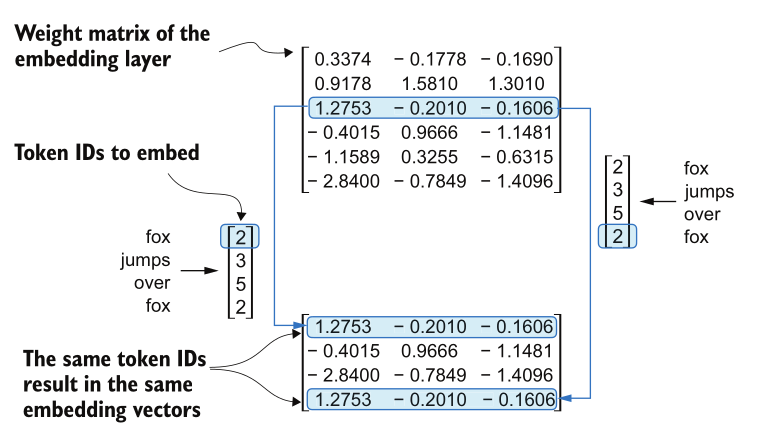

Because of this problem we want to inject position information to our embeddings. There are two approaches to do this:

- **Absolute positional embeddings**: Absolute positional embeddings provide an actual fixed embedding for each position on our input sequence.This embedding then is added to the embedding of the tokenID to obtain the final embedding.
- **Relative positional embeddings**: Instead of focusing on the absolute position of a token, the emphasis of relative positional embeddings is on the relative position or distance between tokens. This means the model learns the relationships in terms of “how far apart” rather than “at which
exact position.” The advantage here is that the model can generalize better to sequences of varying lengths, even if it hasn’t seen such lengths during training.

OpenAI’s GPT models use absolute positional embeddings that are optimized during training. So we basically create another Embedding layer with dimensions (context_length, dim_of_the_embeddings). The input to this layer will usually be a placeholder vector `torch.arange(context_length)`. Finally we simply add these to the token embeddings.

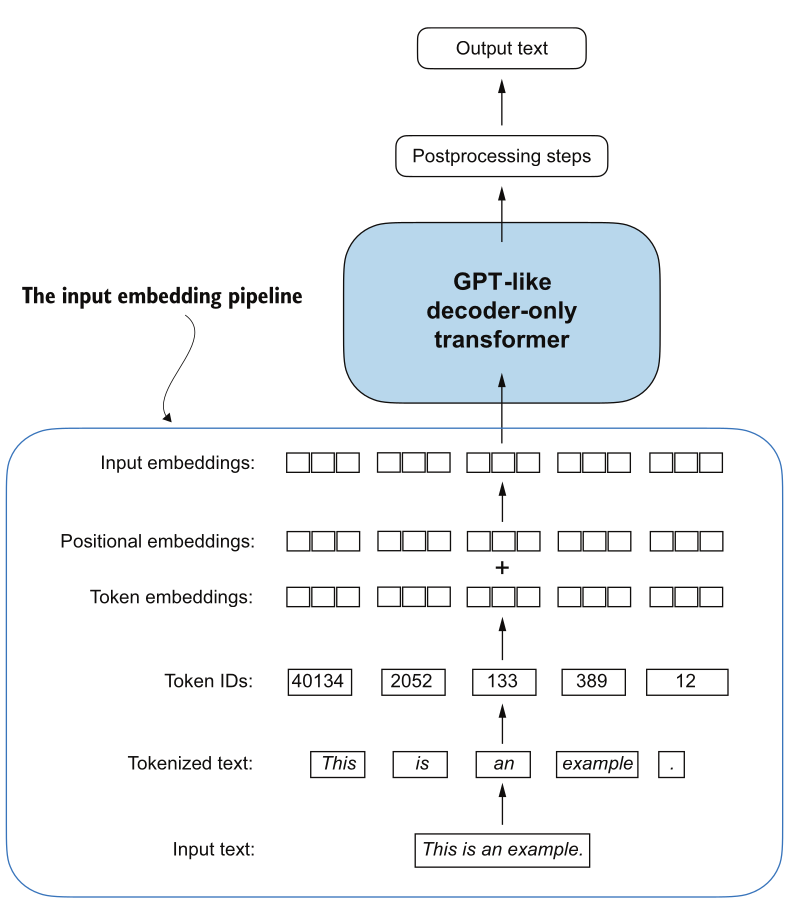